In [1]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, explained_variance_score
from side_info_decoding.utils import load_data_from_pids

In [2]:
def sliding_window_over_time(data, window_size=10):
    
    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - window_size + 1, window_size
        ))
        for t in range(window_size-1, n_t_bins):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t - d]
            data_window[:,:,t-window_size] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        data_window = np.zeros((n_trials, n_t_bins - window_size + 1))
        for t in range(window_size-1, n_t_bins):
            data_window[:,t-window_size] = data[:,t]
    return data_window

#### pupil diameter

In [3]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    '16799c7a-e395-435d-a4c4-a678007e1550',
    '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    '1e176f17-d00f-49bb-87ff-26d237b525f1',
    # '31f3e083-a324-4b88-b0a4-7788ec37b191',
    # "27bac116-ea57-4512-ad35-714a62d259cd",
    # "41a3b948-13f4-4be7-90b9-150705d39005",
    # "63517fd4-ece1-49eb-9259-371dc30b1dd6",
    # "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    # "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    # "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    # "9117969a-3f0d-478b-ad75-98263e3bfacf"
]

In [20]:
save_dir = Path("/home/yizi/side_info_decoding/saved_results/lightning_pose_res_bkp/")
behavior_type = "pupil_diameter"
# behavior_type = "wheel_speed"

In [21]:
baseline_metrics, rrr_metrics = [], []
for pid in pids:
    save_path = save_dir/pid/f"{behavior_type}"
    metrics = np.load(save_path/"metrics.npy", allow_pickle=True).item()[pid]
    baseline_metrics.append(metrics["baseline"])
    rrr_metrics.append(metrics["rrr"])
baseline_metrics = np.array(baseline_metrics)
rrr_metrics = np.array(rrr_metrics)

In [22]:
print(baseline_metrics.mean((0,1))[0])
print(rrr_metrics.mean((0,1))[0])

0.20449827150434793
0.29685200014139257


In [ ]:
print((0.24124580800129 - 0.1567531624693164)/0.24124580800129)

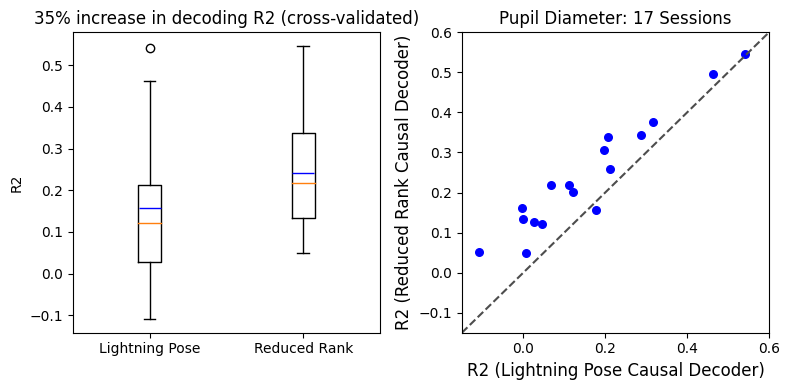

In [160]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.boxplot(
    np.c_[baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0]], 
    showmeans=True, 
    vert=True, patch_artist=False, labels=["Lightning Pose", "Reduced Rank"],
    meanprops={'marker':'_',
               'markerfacecolor':'white', 
               'markeredgecolor':'b',
               'markersize':'16'},
)
ax1.set_ylabel("R2")
ax1.set_title("35% increase in decoding R2 (cross-validated)")

ax2.scatter(baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0], c="blue", s=30)
ax2.set_xlim(-0.15, 0.6)
ax2.set_ylim(-0.15, 0.6)
ax2.set_xlabel("R2 (Lightning Pose Causal Decoder)", fontsize=12)
ax2.set_ylabel("R2 (Reduced Rank Causal Decoder)", fontsize=12)
ax2.plot([-0.15, 0.6], [-0.15, 0.6], ls="--", c=".3")
ax2.set_title(f"Pupil Diameter: {len(pids)} Sessions")

plt.tight_layout()
plt.savefig("/home/yizi/side_info_decoding/saved_plots/lightning_pose_perf.png",
            dpi = 400)

In [23]:
pid = pids[0]
save_path = save_dir/pid/f"{behavior_type}"
traces = np.load(save_path/"traces.npy", allow_pickle=True).item()[pid]
baseline_traces = traces["baseline"]
rrr_traces = traces["rrr"]

In [24]:
obs_traces = {}
for pid in [pid]:
    
    obs_traces[pid] = []
    
    X_dict, Y_dict = load_data_from_pids(
        [pid],
        brain_region="all",
        behavior=behavior_type,
        data_type="all_ks",
        n_t_bins = 60,
        align_time_type="firstMovement_times",
        # align_time_type="response_times",
        t_before=0.2,
        t_after=1.0,
        normalize_input=False
    )
    
    X, Y = X_dict[pid], Y_dict[pid]
    offset = Y.max()
    Y /= offset
    window_Y = sliding_window_over_time(Y, window_size=10)
    
    xval_traces = []
    kf = KFold(n_splits=5, shuffle=True, random_state=666)
    for train, test in kf.split(X, Y):
        xval_traces.append(window_Y[test])
        
    obs_traces[pid].append(xval_traces)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367
found 367 trials from 17.75 to 2310.37 sec.


Compute spike count: 100%|███████████████████| 367/367 [00:02<00:00, 160.47it/s]


In [25]:
obs_traces[pid] = np.concatenate(np.concatenate(obs_traces[pid]))

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [26]:
SMALL_SIZE = 15
MEDIUM_SIZE = 12
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = .5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

0.6922870700353395
-1.4558901843129544
-4.298944431143719
-12.356585793160784
-0.7611062568942744
-2.3435855767402143
-0.5664731633061384
0.25868250703814943
-2.4837970843816697
-2.845317355201449


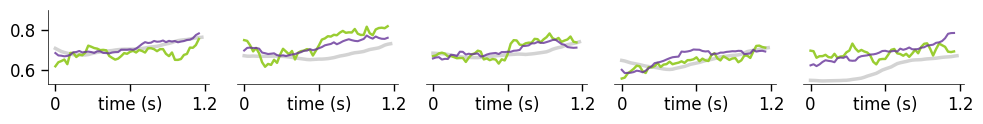

In [27]:
fig, axes = plt.subplots(1,5,figsize=(10,1.4))

chosen_trails = [1,4,5,34,36]
for i, idx in enumerate(chosen_trails):
    
    axes[i].plot(obs_traces[pid][idx].flatten()[:-1], c="lightgray", linewidth=2.5, label="pupil diameter")
    axes[i].plot(baseline_traces[-1][idx].flatten()[:-1], c="yellowgreen", linewidth=1.75, label="ridge regression")
    axes[i].plot(rrr_traces[-1][idx].flatten()[:-1], c="rebeccapurple", alpha=.8, linewidth=1.5, label="reduced rank model")
    axes[i].set_ylim([0.53, .9])
    print(r2_score(obs_traces[pid][idx].flatten()[:-1], rrr_traces[-1][idx].flatten()))
    print(r2_score(obs_traces[pid][idx].flatten()[:-1], baseline_traces[-1][idx].flatten()))
    
    if i == 0:
        # axes[i].set_yticks([0.4, 0.55, 0.7, 0.85, 1.0], [0.4, 0.55, "AUC", 0.85, 1.0], fontsize=10)
        # axes[i].set_yticks([0.6, 0.7, 0.8], [0.6, 0.7, 0.8], fontsize=10)
        axes[i].spines[['right', 'top']].set_visible(False)
    else:
        axes[i].spines[['right', 'top', 'left']].set_visible(False)
        axes[i].set_yticks([], [])
    axes[i].set_ylabel("")
    axes[i].tick_params('both', length=5, width=1, which='major')
    axes[i].tick_params('both', length=5, width=1, which='minor')
        
    axes[i].set_xticks([0, 25, 50], [0, "time (s)",1.2])
    # axes[i].legend(bbox_to_anchor=(1.05,1.5), ncol=3, frameon=False)
    
# ax.set_title("pupil diameter")
plt.tight_layout()
# plt.savefig("./figures/wheel_traces.png", dpi = 400)
# plt.savefig("../biorxiv_plots/plots/pupil_diameter.png", dpi = 400)

In [15]:
from sklearn.metrics import r2_score

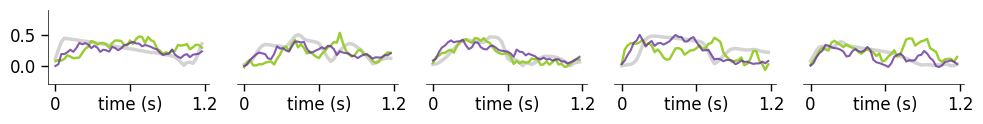

In [19]:
fig, axes = plt.subplots(1,5,figsize=(10,1.4))

chosen_trails = [1,6,7,22,25]
for i, idx in enumerate(chosen_trails):
    
    axes[i].plot(obs_traces[pid][idx].flatten()[:-1], c="lightgray", linewidth=2.5, label="pupil diameter")
    axes[i].plot(baseline_traces[-1][idx].flatten()[:-1], c="yellowgreen", linewidth=1.75, label="ridge regression")
    axes[i].plot(rrr_traces[-1][idx].flatten()[:-1], c="rebeccapurple", alpha=.8, linewidth=1.5, label="reduced rank model")
    axes[i].set_ylim([-.3, .9])
    
    if i == 0:
        # axes[i].set_yticks([0.4, 0.55, 0.7, 0.85, 1.0], [0.4, 0.55, "AUC", 0.85, 1.0], fontsize=10)
        # axes[i].set_yticks([0.6, 0.7, 0.8], [0.6, 0.7, 0.8], fontsize=10)
        axes[i].spines[['right', 'top']].set_visible(False)
    else:
        axes[i].spines[['right', 'top', 'left']].set_visible(False)
        axes[i].set_yticks([], [])
    axes[i].set_ylabel("")
    axes[i].tick_params('both', length=5, width=1, which='major')
    axes[i].tick_params('both', length=5, width=1, which='minor')
        
    axes[i].set_xticks([0, 25, 50], [0, "time (s)",1.2])
    # axes[i].legend(bbox_to_anchor=(1.05,1.5), ncol=3, frameon=False)
    
# ax.set_title("pupil diameter")
plt.tight_layout()
# plt.savefig("../biorxiv_plots/plots/wheel_traces.png", dpi = 400)
# plt.savefig("../biorxiv_plots/plots/pupil_diameter.png", dpi = 400)

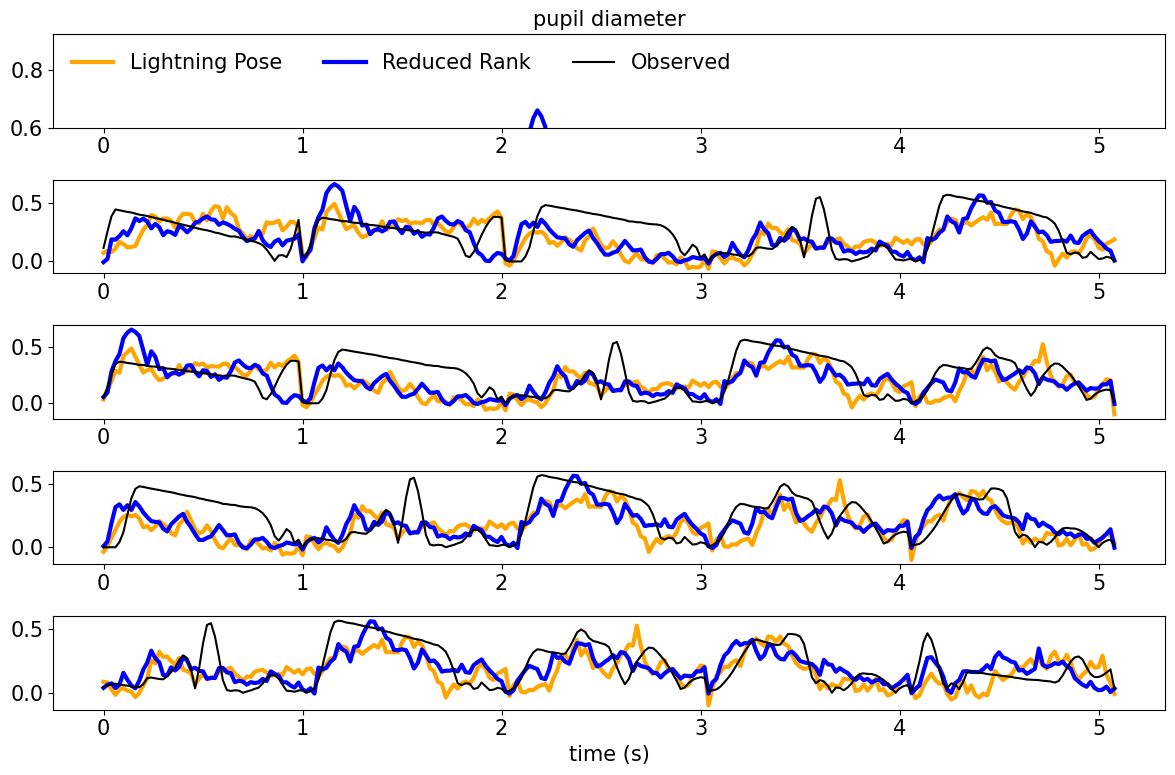

In [125]:
fig, axes = plt.subplots(5,1,figsize=(12,8))
for i, ax in enumerate(axes):
    ax.plot(baseline_traces[-1][i:i+5].flatten(), c="orange", linewidth=3, label="Lightning Pose")
    ax.plot(rrr_traces[-1][i:i+5].flatten(), c="b", linewidth=3, label="Reduced Rank")
    ax.plot(obs_traces[pid][i:i+5].flatten(), c="k", label="Observed")
    ax.set_xticks([0, 50, 100, 150, 200, 250], [0, 1, 2, 3, 4, 5])
    if i == 0:
        ax.set_title("pupil diameter")
        ax.legend(loc="upper left", ncol=3, frameon=False)
        ax.set_ylim(0.6, .925)
ax.set_xlabel("time (s)")
plt.tight_layout()
# plt.savefig("/home/yizi/side_info_decoding/saved_plots/lightning_pose_traces.png",
#             dpi = 400)

In [3]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    '16799c7a-e395-435d-a4c4-a678007e1550',
    '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    '1e176f17-d00f-49bb-87ff-26d237b525f1',
    '31f3e083-a324-4b88-b0a4-7788ec37b191',
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "41a3b948-13f4-4be7-90b9-150705d39005",
    "63517fd4-ece1-49eb-9259-371dc30b1dd6",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf"
]

In [4]:
save_dir = Path("/home/yizi/side_info_decoding/saved_results/lightning_pose_res/")
behavior_type = "paw_speed"

In [5]:
baseline_metrics, rrr_metrics = [], []
for pid in pids:
    save_path = save_dir/pid/f"{behavior_type}"
    metrics = np.load(save_path/"metrics.npy", allow_pickle=True).item()[pid]
    baseline_metrics.append(metrics["baseline"])
    rrr_metrics.append(metrics["rrr"])
baseline_metrics = np.array(baseline_metrics)
rrr_metrics = np.array(rrr_metrics)

In [6]:
print(baseline_metrics.mean((0,1))[0])
print(rrr_metrics.mean((0,1))[0])

-0.12431640231277413
0.004293101585630106


In [7]:
print((0.004293101585630106 - -0.12431640231277413)/-0.12431640231277413)

-1.0345336697793817


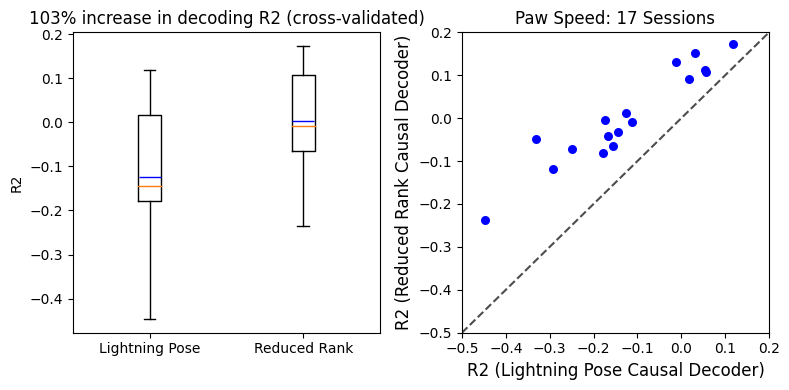

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.boxplot(
    np.c_[baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0]], 
    showmeans=True, 
    vert=True, patch_artist=False, labels=["Lightning Pose", "Reduced Rank"],
    meanprops={'marker':'_',
               'markerfacecolor':'white', 
               'markeredgecolor':'b',
               'markersize':'16'},
)
ax1.set_ylabel("R2")
ax1.set_title("103% increase in decoding R2 (cross-validated)")

ax2.scatter(baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0], c="blue", s=30)
ax2.set_xlim(-0.5, 0.2)
ax2.set_ylim(-0.5, 0.2)
ax2.set_xlabel("R2 (Lightning Pose Causal Decoder)", fontsize=12)
ax2.set_ylabel("R2 (Reduced Rank Causal Decoder)", fontsize=12)
ax2.plot([-0.5, 0.2], [-0.5, 0.2], ls="--", c=".3")
ax2.set_title(f"Paw Speed: {len(pids)} Sessions")

plt.tight_layout()
# plt.savefig("/home/yizi/side_info_decoding/saved_plots/lightning_pose_perf.png",
#             dpi = 400)

In [24]:
pid = pids[0]
save_path = save_dir/pid/f"{behavior_type}"
traces = np.load(save_path/"traces.npy", allow_pickle=True).item()[pid]
baseline_traces = traces["baseline"]
rrr_traces = traces["rrr"]
obs_traces = traces["obs"]

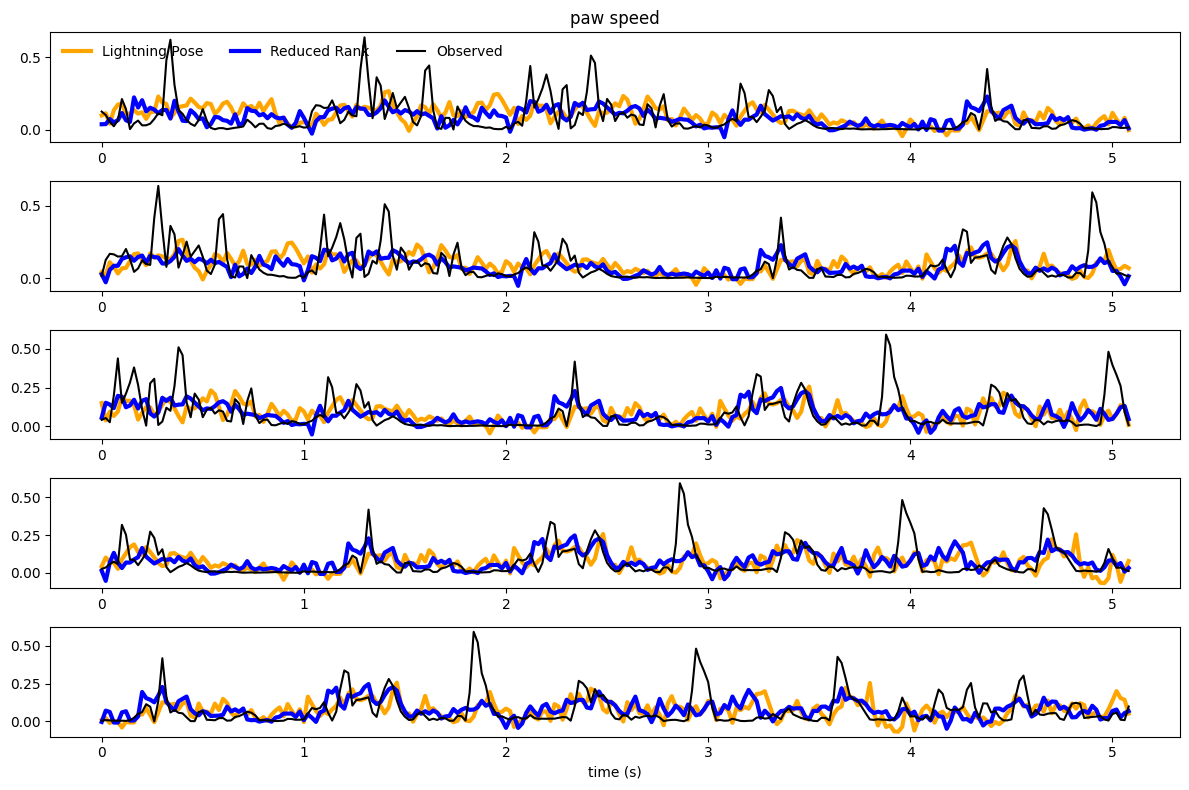

In [26]:
fig, axes = plt.subplots(5,1,figsize=(12,8))
for i, ax in enumerate(axes):
    ax.plot(baseline_traces[-1][i:i+5].flatten(), c="orange", linewidth=3, label="Lightning Pose")
    ax.plot(rrr_traces[-1][i:i+5].flatten(), c="b", linewidth=3, label="Reduced Rank")
    ax.plot(obs_traces[-1][i:i+5].flatten(), c="k", label="Observed")
    ax.set_xticks([0, 50, 100, 150, 200, 250], [0, 1, 2, 3, 4, 5])
    if i == 0:
        ax.set_title("paw speed")
        ax.legend(loc="upper left", ncol=3, frameon=False)
        # ax.set_ylim(0.6, .925)
ax.set_xlabel("time (s)")
plt.tight_layout()
# plt.savefig("/home/yizi/side_info_decoding/saved_plots/lightning_pose_traces.png",
#             dpi = 400)